In [1]:
import jax 
jax.config.update("jax_enable_x64", True)
import cfp
import scanpy as sc
import anndata as ad
import numpy as np
import cfp.preprocessing as cfpp
import pandas as pd

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [43]:
split = 5
model_name = "bumbling-leaf-359"

adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
    



In [44]:
covariate_data_ood = adata_ood[~adata_ood.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])
covariate_data_test = adata_test[~adata_test.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])


In [45]:
covariate_data = covariate_data_test[(covariate_data_test["cell_line"]=="MCF7") & (covariate_data_test["drug"]=="Pracinostat_(SB939)")]

In [46]:
covariate_data

cell_type  dose dose_character dose_pattern  \
index                                                                          
A03_E09_RT_BC_253_Lig_BC_275-1-0      MCF7  10.0             10            4   

                                 g1s_score g2m_score                 pathway  \
index                                                                          
A03_E09_RT_BC_253_Lig_BC_275-1-0  2.142349  1.893047  Cytoskeletal Signaling   

                                        pathway_level_1  \
index                                                     
A03_E09_RT_BC_253_Lig_BC_275-1-0  Epigenetic regulation   

                                        pathway_level_2  \
index                                                     
A03_E09_RT_BC_253_Lig_BC_275-1-0  Histone deacetylation   

                                            product_dose  ... pubchem_name  \
index                                                     ...                
A03_E09_RT_BC_253_Lig_BC_275-1-0  Pracinostat (SB939)_10  ...  Pracinostat   

                                 pubchem_ID  \
index                                         
A03_E09_RT_BC_253_Lig_BC_275-1-0   49855250   

                                                                        smiles  \
index                                                                            
A03_E09_RT_BC_253_Lig_BC_275-1-0  CCCCC1=NC2=C(N1CCN(CC)CC)C=CC(=C2)C=CC(=O)NO   

                                 control    ood_1    ood_2  \
index                                                        
A03_E09_RT_BC_253_Lig_BC_275-1-0   False  not ood  not ood   

                                                          ood_3    ood_4  \
index                                                                      
A03_E09_RT_BC_253_Lig_BC_275-1-0  MCF7_Pracinostat_(SB939)_10.0  not ood   

                                    ood_5 split  
index                                            
A03_E09_RT_BC_253_Lig_BC_275-1-0  not ood  test  

[1 rows x 32 columns]

In [47]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.linspace(start, end, steps)  # Interpolate 'logdose'
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result

covariate_data_interpolated = duplicate_and_interpolate(covariate_data, 'logdose', 1.0, 4.0, 8)

In [48]:
adata_ood_ctrl = adata_ood[(adata_ood.obs["condition"].str.contains("Vehicle")) & (adata_ood.obs["cell_line"]=="MCF7")]
adata_ood_ctrl.obs["control"] = True

/tmp/ipykernel_2818934/493568434.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_ctrl.obs["control"] = True


In [49]:
adata_ood_ctrl.obs["condition"].value_counts()

condition
MCF7_Vehicle_0.0    500
Name: count, dtype: int64

In [50]:
cf = cfp.model.CellFlow.load(f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/out/{model_name}_CellFlow.pkl")



In [51]:
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.cell_type, x.drug, str(x.logdose)]), axis=1)

In [52]:
len(covariate_data_ood_new)

8

In [53]:
sc.pp.subsample(adata_ood_ctrl, fraction=0.2)

In [54]:
preds_ood = cf.predict(adata=adata_ood_ctrl, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_interpolated)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 8/8 [00:00<00:00, 606.98it/s]


In [55]:
all_data = []
conditions = []

for condition, array in preds_ood.items():
    all_data.append(array)
    conditions.extend([condition] * array.shape[0])

# Stack all data vertically to create a single array
all_data_array = np.vstack(all_data)

# Create a DataFrame for the .obs attribute
obs_data = pd.DataFrame({
    'condition': conditions
})

# Create the Anndata object
adata_ood_result = ad.AnnData(X=np.empty((len(all_data_array),2001)), obs=obs_data)
adata_ood_result.obsm["X_pca_pred"] = all_data_array


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [56]:
cfpp.reconstruct_pca(query_adata=adata_ood_result, use_rep="X_pca_pred", ref_adata=adata_train, layers_key_added="X_recon_pred")


In [57]:
adata_ood_result.X = adata_ood_result.layers["X_recon_pred"]

In [58]:
sc.pp.pca(adata_ood_result)
sc.pp.neighbors(adata_ood_result)
sc.tl.umap(adata_ood_result)

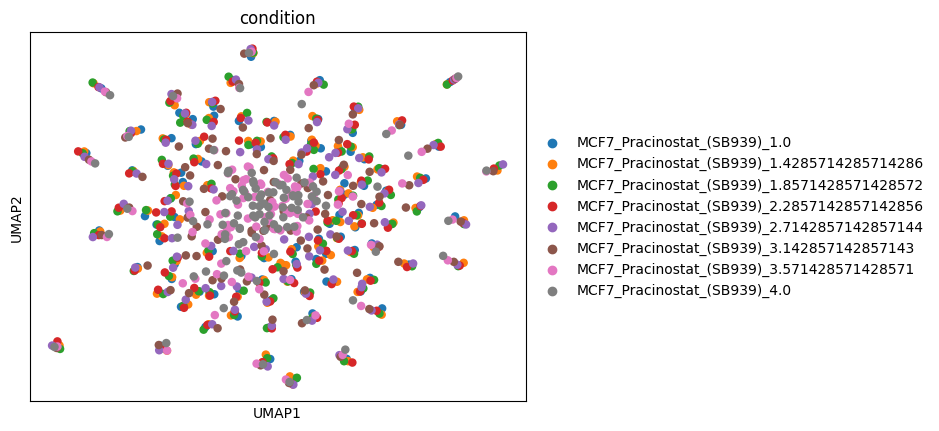

In [59]:
sc.pl.umap(adata_ood_result, color="condition")

In [60]:
adata_pred = adata_ood_result

In [61]:
adata_true = adata_test[(adata_test.obs["drug"]=="Pracinostat_(SB939)") & (adata_test.obs["cell_type"]=="MCF7")]

In [62]:
adata_pred.var_names = adata_true.var_names

In [63]:
adata_true.obs["mode"] = "True"
adata_pred.obs["mode"] = "pred"

/tmp/ipykernel_2818934/4144871509.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_true.obs["mode"] = "True"


In [64]:
adata_joint = ad.concat((adata_true, adata_pred))

In [67]:
sc.pp.pca(adata_joint, n_comps=5)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)

In [90]:
adata_joint.obs["dose"] = adata_joint.obs.apply(lambda x: x["condition"].split("_")[-1], axis=1)

In [91]:
adata_joint.obs["dose"] =adata_joint.obs["dose"].astype("float") 

In [92]:
adata_joint.obs["logdose"] = adata_joint.obs.apply(lambda x: np.log10(x["dose"]) if (x["dose"] in [10, 100, 1000, 10000]) else x["dose"], axis=1)

In [93]:
adata_joint.obs["logdose"].value_counts()

logdose
1.000000    150
4.000000    150
1.857143    100
1.428571    100
2.714286    100
2.285714    100
3.142857    100
3.571429    100
3.000000     50
2.000000     50
Name: count, dtype: int64

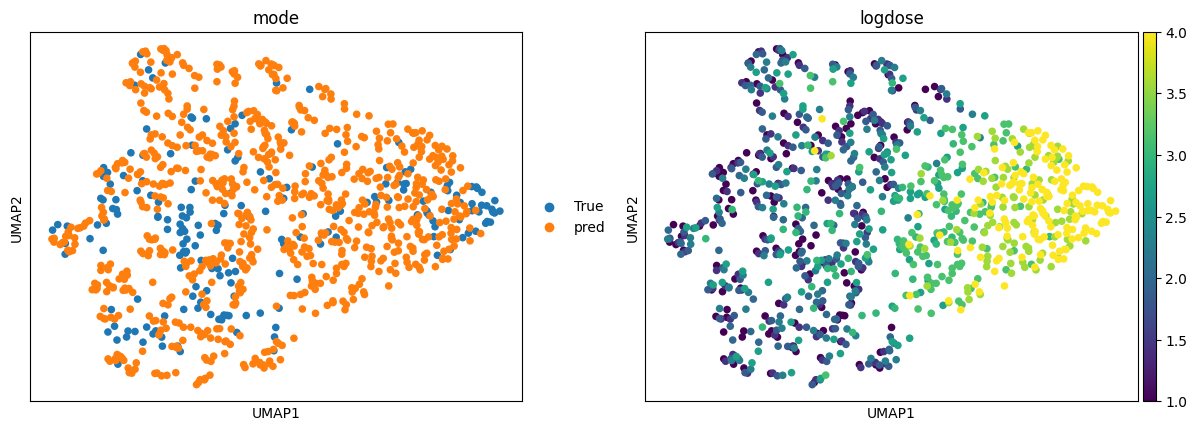

In [94]:
sc.pl.umap(adata_joint, color=["mode", "logdose"])

In [234]:
sc.pp.neighbors(adata_ood_result,use_rep="X_pca_pred")
sc.tl.umap(adata_ood_result)

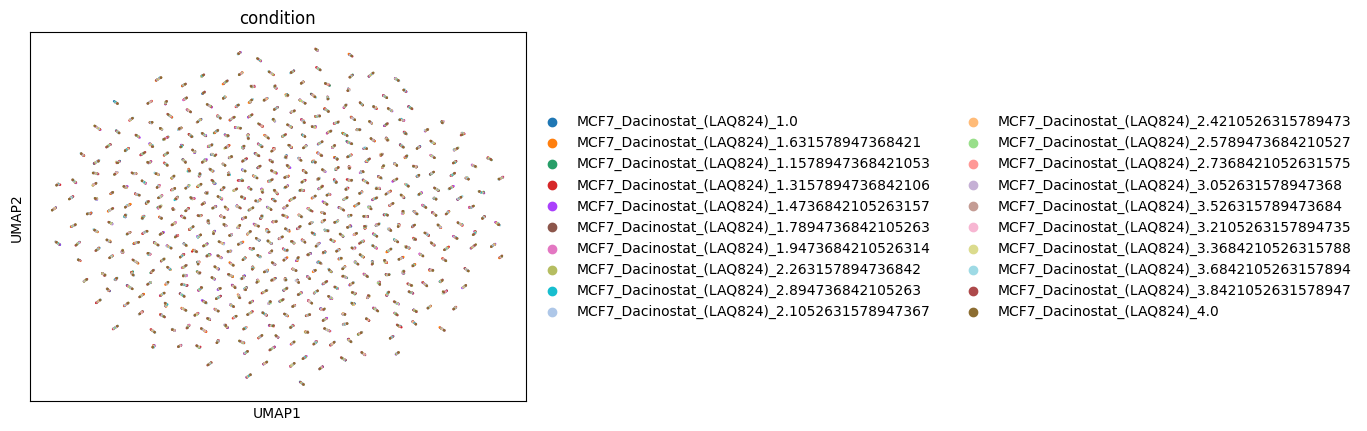

In [235]:
sc.pl.umap(adata_ood_result, color="condition")

In [220]:
adata_ood_result.obs["dose"] = adata_ood_result.obs.apply(get_dose_from_condition, axis=1)

In [221]:
adata_ood_true = adata_ood[(adata_ood.obs["cell_line"]=="MCF7") & (adata_ood.obs["drug"]=="Dacinostat_(LAQ824)")]

In [222]:
adata_ood_true.obs["condition"].value_counts()

condition
MCF7_Dacinostat_(LAQ824)_10.0       454
MCF7_Dacinostat_(LAQ824)_10000.0    435
MCF7_Dacinostat_(LAQ824)_1000.0     358
MCF7_Dacinostat_(LAQ824)_100.0      320
Name: count, dtype: int64

In [223]:
adata_all = ad.concat((adata_ood_true, adata_ood_result), join="outer")

In [224]:
adata_all.obs

cell_type     dose dose_character  \
A01_E09_RT_BC_129_Lig_BC_265-1-0      MCF7     10.0             10   
A01_E09_RT_BC_152_Lig_BC_328-1-0      MCF7  10000.0          10000   
A01_E09_RT_BC_202_Lig_BC_303-1-0      MCF7    100.0            100   
A01_E09_RT_BC_219_Lig_BC_335-1-0      MCF7   1000.0           1000   
A01_E09_RT_BC_274_Lig_BC_119-1-0      MCF7     10.0             10   
...                                    ...      ...            ...   
9995                                   NaN      4.0            NaN   
9996                                   NaN      4.0            NaN   
9997                                   NaN      4.0            NaN   
9998                                   NaN      4.0            NaN   
9999                                   NaN      4.0            NaN   

                                 dose_pattern g1s_score g2m_score  \
A01_E09_RT_BC_129_Lig_BC_265-1-0            4  2.092470  0.884173   
A01_E09_RT_BC_152_Lig_BC_328-1-0            1  2.853289  1.964209   
A01_E09_RT_BC_202_Lig_BC_303-1-0            3  1.487790  1.487790   
A01_E09_RT_BC_219_Lig_BC_335-1-0            2  1.663198  2.003402   
A01_E09_RT_BC_274_Lig_BC_119-1-0            4  0.963303  0.963303   
...                                       ...       ...       ...   
9995                                      NaN       NaN       NaN   
9996                                      NaN       NaN       NaN   
9997                                      NaN       NaN       NaN   
9998                                      NaN       NaN       NaN   
9999                                      NaN       NaN       NaN   

                                      pathway        pathway_level_1  \
A01_E09_RT_BC_129_Lig_BC_265-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_202_Lig_BC_303-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_219_Lig_BC_335-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_274_Lig_BC_119-1-0  Epigenetics  Epigenetic regulation   
...                                       ...                    ...   
9995                                      NaN                    NaN   
9996                                      NaN                    NaN   
9997                                      NaN                    NaN   
9998                                      NaN                    NaN   
9999                                      NaN                    NaN   

                                        pathway_level_2  \
A01_E09_RT_BC_129_Lig_BC_265-1-0  Histone deacetylation   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Histone deacetylation   
A01_E09_RT_BC_202_Lig_BC_303-1-0  Histone deacetylation   
A01_E09_RT_BC_219_Lig_BC_335-1-0  Histone deacetylation   
A01_E09_RT_BC_274_Lig_BC_119-1-0  Histone deacetylation   
...                                                 ...   
9995                                                NaN   
9996                                                NaN   
9997                                                NaN   
9998                                                NaN   
9999                                                NaN   

                                               product_dose  ... pubchem_name  \
A01_E09_RT_BC_129_Lig_BC_265-1-0     Dacinostat (LAQ824)_10  ...          NaN   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Dacinostat (LAQ824)_10000  ...          NaN   
A01_E09_RT_BC_202_Lig_BC_303-1-0    Dacinostat (LAQ824)_100  ...          NaN   
A01_E09_RT_BC_219_Lig_BC_335-1-0   Dacinostat (LAQ824)_1000  ...          NaN   
A01_E09_RT_BC_274_Lig_BC_119-1-0     Dacinostat (LAQ824)_10  ...          NaN   
...                                                     ...  ...          ...   
9995                                                    NaN  ...          NaN   
9996                                                    NaN  ...          NaN   
9997                                                    NaN 

In [225]:
sc.pp.pca(adata_all)

In [226]:
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

In [229]:
adata_ood.obs["logdose"]

index
A01_E09_RT_BC_108_Lig_BC_256-0-0    1.0
A01_E09_RT_BC_116_Lig_BC_193-0-0    1.0
A01_E09_RT_BC_129_Lig_BC_15-0-0     4.0
A01_E09_RT_BC_136_Lig_BC_372-0-0    3.0
A01_E09_RT_BC_136_Lig_BC_6-0-0      3.0
                                   ... 
H12_E09_RT_BC_353_Lig_BC_331-1      0.0
H12_E09_RT_BC_85_Lig_BC_284-1       0.0
H12_F10_RT_BC_151_Lig_BC_60-1       0.0
H12_F10_RT_BC_383_Lig_BC_377-1      0.0
H12_F10_RT_BC_75_Lig_BC_115-1       0.0
Name: logdose, Length: 20173, dtype: category
Categories (5, float64): [0.0, 1.0, 2.0, 3.0, 4.0]

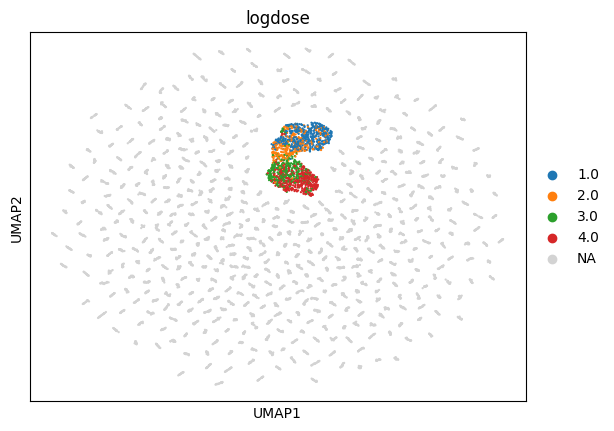

In [232]:
sc.pl.umap(adata_all, color="logdose")

In [186]:
res = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/results/allocation/ood_metrics_decoded.csv")

In [199]:
res[(res.model=="otfm") & (res["split"]==5) & (res["variable"].str.contains("10000"))].sort_values("value")

Unnamed: 0 model     metric  \
11002         377  otfm  r_squared   
10912         287  otfm  r_squared   
10842         217  otfm  r_squared   
10702          77  otfm  r_squared   
10982         357  otfm  r_squared   
11037         412  otfm  r_squared   
10682          57  otfm  r_squared   
10962         337  otfm  r_squared   
10932         307  otfm  r_squared   

                                           variable     value  split  
11002  MCF7_Quisinostat_(JNJ-26481585)_2HCl_10000.0  0.675042      5  
10912              MCF7_Belinostat_(PXD101)_10000.0  0.696236      5  
10842                       K562_Hesperadin_10000.0  0.763719      5  
10702             A549_Givinostat_(ITF2357)_10000.0  0.772818      5  
10982                       MCF7_Hesperadin_10000.0  0.860060      5  
11037            MCF7_Tanespimycin_(17-AAG)_10000.0  0.879834      5  
10682                 A549_Flavopiridol_HCl_10000.0  0.945265      5  
10962             MCF7_Givinostat_(ITF2357)_10000.0  0.953000      5  
10932              MCF7_Dacinostat_(LAQ824)_10000.0  0.960307      5

In [195]:
res[(res.model=="otfm")]

Unnamed: 0 model     metric                            variable  \
2               2  otfm  r_squared                   A549_(+)-JQ1_10.0   
7               7  otfm  r_squared                  A549_(+)-JQ1_100.0   
12             12  otfm  r_squared                 A549_(+)-JQ1_1000.0   
17             17  otfm  r_squared                A549_(+)-JQ1_10000.0   
22             22  otfm  r_squared        A549_AC480_(BMS-599626)_10.0   
...           ...   ...        ...                                 ...   
11017         392  otfm  r_squared                 MCF7_TAK-901_1000.0   
11022         397  otfm  r_squared     MCF7_Tanespimycin_(17-AAG)_10.0   
11027         402  otfm  r_squared    MCF7_Tanespimycin_(17-AAG)_100.0   
11032         407  otfm  r_squared   MCF7_Tanespimycin_(17-AAG)_1000.0   
11037         412  otfm  r_squared  MCF7_Tanespimycin_(17-AAG)_10000.0   

          value  split  
2      0.986635      1  
7      0.957462      1  
12     0.865279      1  
17     0.843068      1  
22     0.989673      1  
...         ...    ...  
11017  0.921915      5  
11022  0.972406      5  
11027  0.908560      5  
11032  0.891221      5  
11037  0.879834      5  

[2208 rows x 6 columns]

In [188]:
adata_all.obs["condition"].value_counts()

condition
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.0                   500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.5789473684210527    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_4.0                   500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.8421052631578947    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.6842105263157894    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.3684210526315788    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.2105263157894735    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.526315789473684     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.052631578947368     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.631578947368421     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.7368421052631575    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.4210526315789473    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.1052631578947367    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.894736842105263     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.263157894736842     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.947368

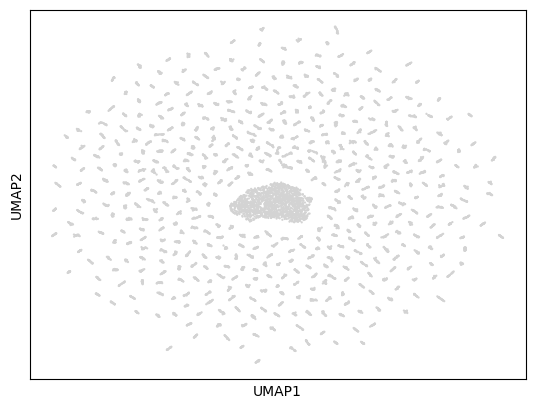

In [185]:
sc.pl.umap(adata_all)

In [ ]:
covariate_data_ood = covariate_data_ood[(covariate_data_ood["cell_line"]=="MCF7") & (covariate_data_ood["drug"]=="Quisinostat_(JNJ-26481585)_2HCl")]

In [66]:
adata_ood_result.write("/lustre/groups/ml01/workspace/ot_perturbation/analysis/sciplex/pseudodosages_split_5.h5ad")

In [67]:
sc.pp.pca(adata_ood_result)

In [68]:
sc.pp.neighbors(adata_ood_result)
sc.tl.umap(adata_ood_result)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


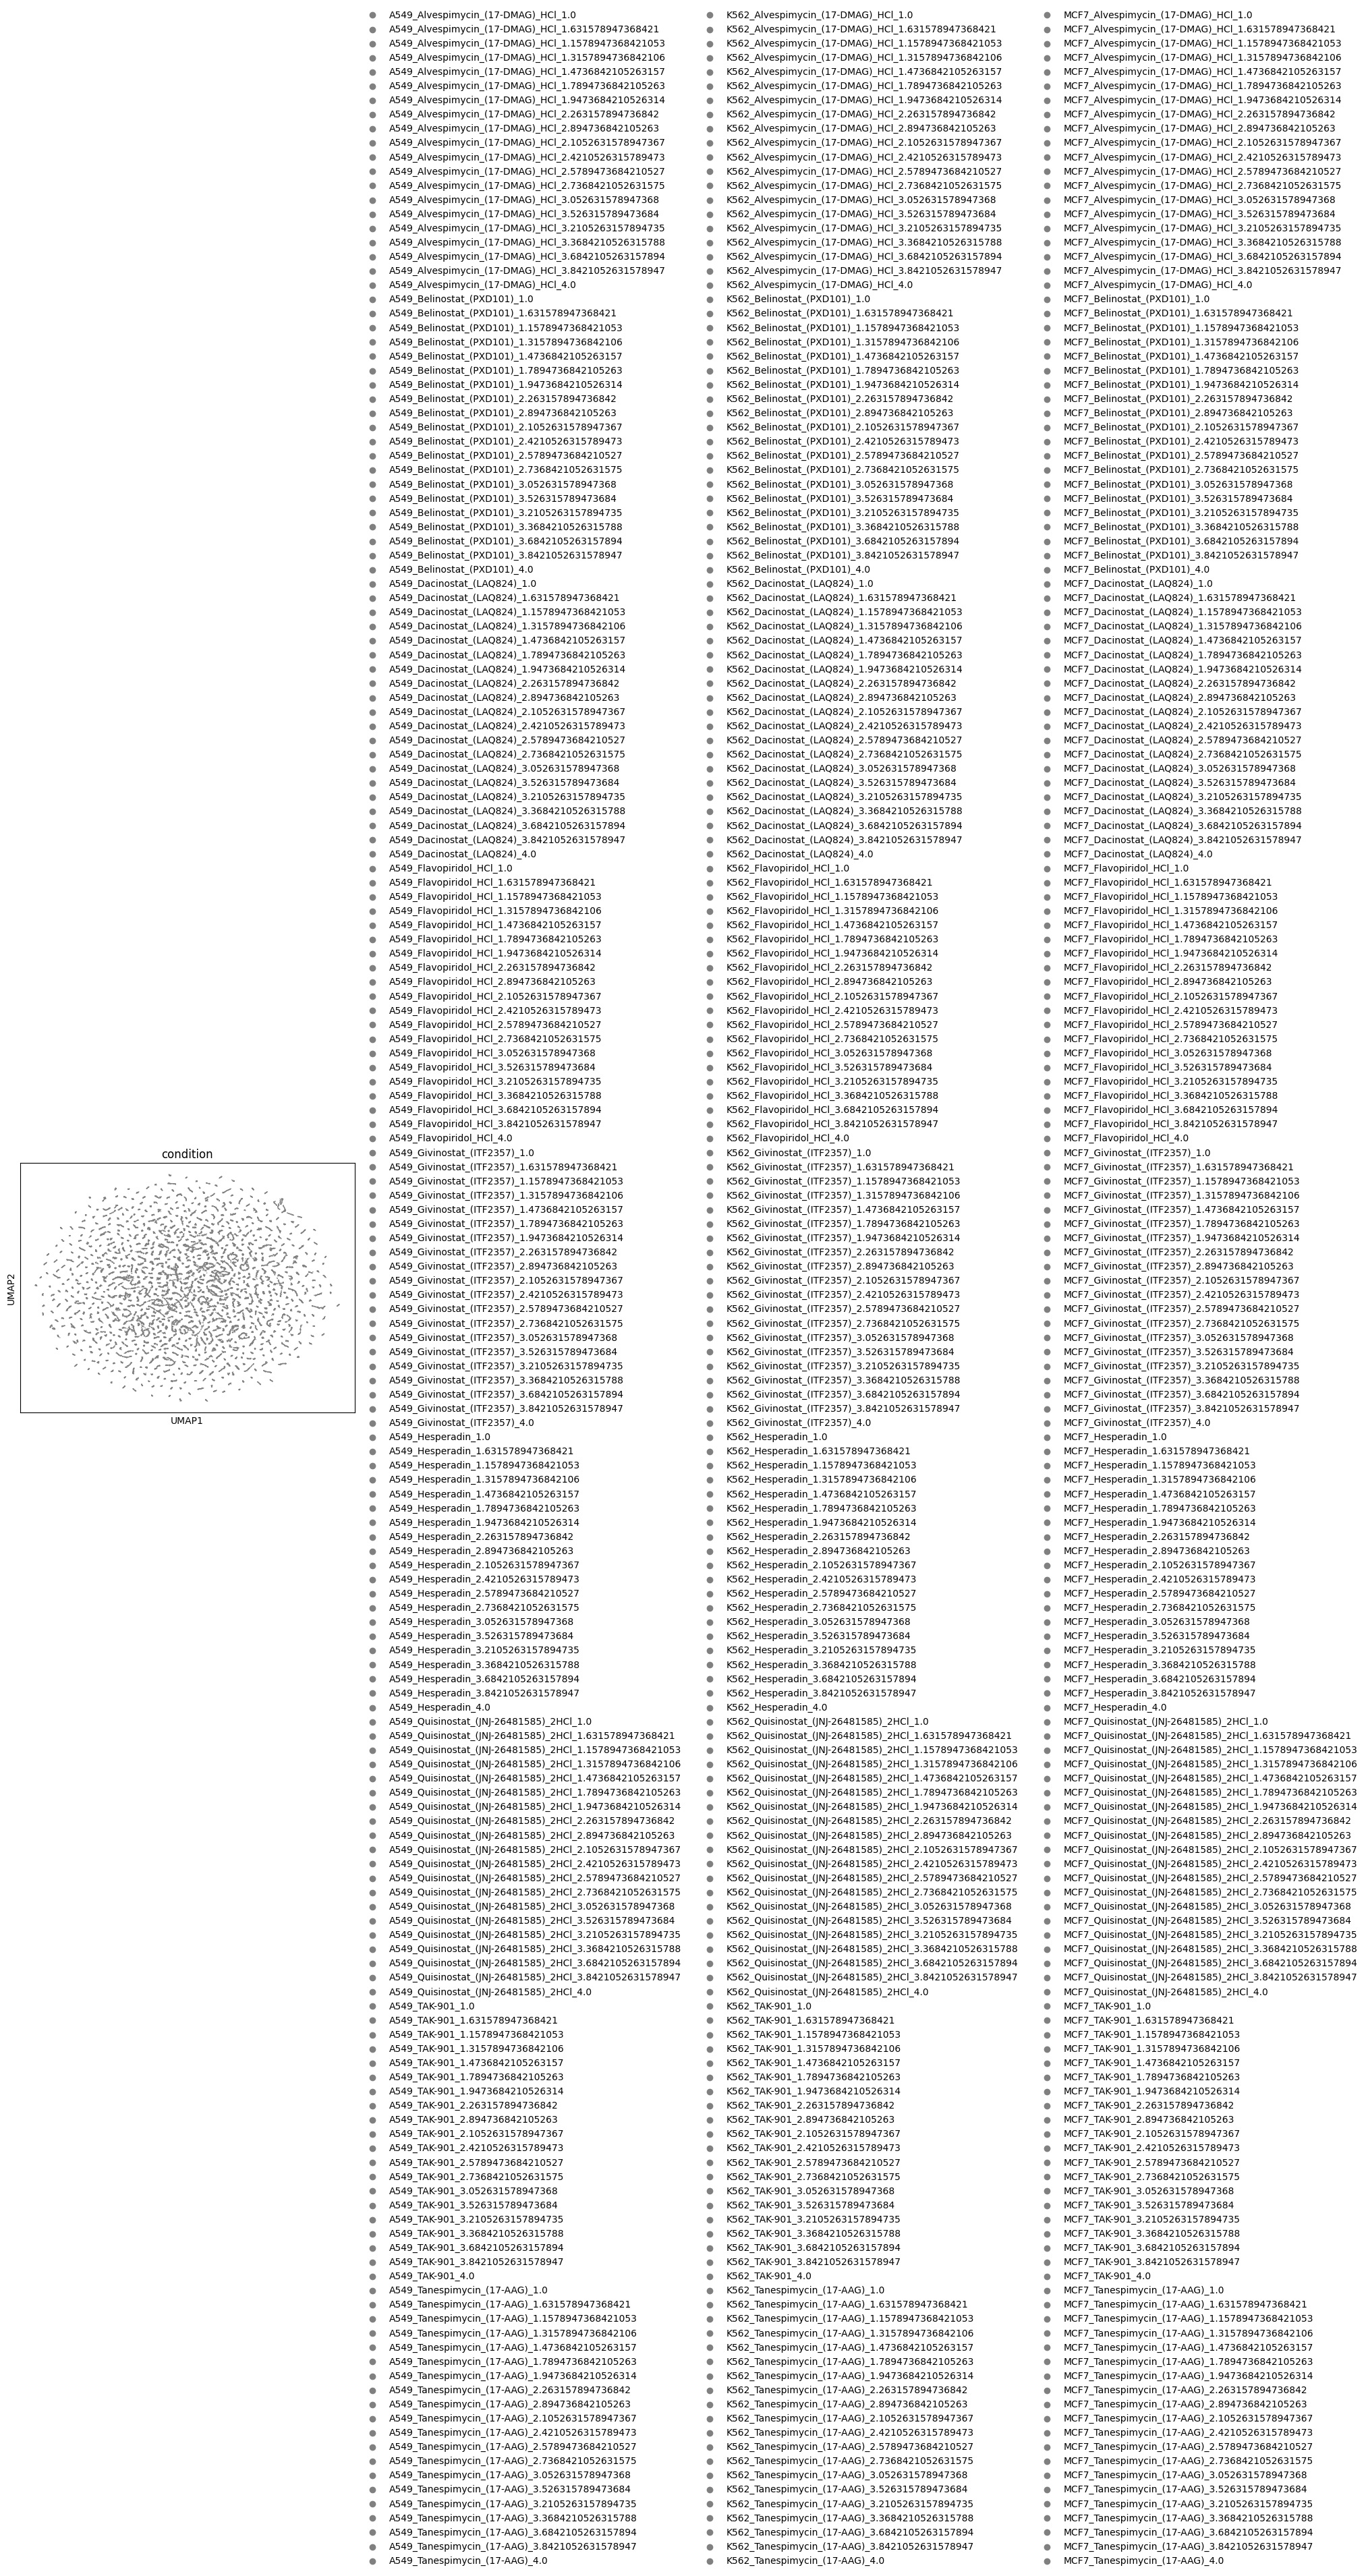

In [69]:
sc.pl.umap(adata_ood_result, color="condition")

In [128]:
conds_to_choose = [el for el in adata_ood_result.obs["condition"].unique() if "MCF7_Givin" in el]

In [129]:
conds_to_choose

['MCF7_Givinostat_(ITF2357)_1.0',
 'MCF7_Givinostat_(ITF2357)_1.1578947368421053',
 'MCF7_Givinostat_(ITF2357)_1.3157894736842106',
 'MCF7_Givinostat_(ITF2357)_1.4736842105263157',
 'MCF7_Givinostat_(ITF2357)_1.631578947368421',
 'MCF7_Givinostat_(ITF2357)_1.7894736842105263',
 'MCF7_Givinostat_(ITF2357)_1.9473684210526314',
 'MCF7_Givinostat_(ITF2357)_2.1052631578947367',
 'MCF7_Givinostat_(ITF2357)_2.263157894736842',
 'MCF7_Givinostat_(ITF2357)_2.4210526315789473',
 'MCF7_Givinostat_(ITF2357)_2.5789473684210527',
 'MCF7_Givinostat_(ITF2357)_2.7368421052631575',
 'MCF7_Givinostat_(ITF2357)_2.894736842105263',
 'MCF7_Givinostat_(ITF2357)_3.052631578947368',
 'MCF7_Givinostat_(ITF2357)_3.2105263157894735',
 'MCF7_Givinostat_(ITF2357)_3.3684210526315788',
 'MCF7_Givinostat_(ITF2357)_3.526315789473684',
 'MCF7_Givinostat_(ITF2357)_3.6842105263157894',
 'MCF7_Givinostat_(ITF2357)_3.8421052631578947',
 'MCF7_Givinostat_(ITF2357)_4.0']

In [130]:
adata_ood_result.obs["condition"].value_counts()

condition
A549_Alvespimycin_(17-DMAG)_HCl_1.0         56
A549_Hesperadin_3.526315789473684           56
A549_Hesperadin_3.3684210526315788          56
A549_Hesperadin_3.6842105263157894          56
A549_Hesperadin_3.8421052631578947          56
                                            ..
MCF7_Flavopiridol_HCl_1.631578947368421     46
MCF7_Flavopiridol_HCl_1.1578947368421053    46
MCF7_Flavopiridol_HCl_1.3157894736842106    46
MCF7_Flavopiridol_HCl_1.4736842105263157    46
MCF7_Tanespimycin_(17-AAG)_4.0              46
Name: count, Length: 540, dtype: int64

In [131]:

bdata = adata_ood_result[adata_ood_result.obs["condition"].isin(conds_to_choose)]

In [132]:
bdata.obs["condition"].value_counts()


condition
MCF7_Givinostat_(ITF2357)_1.0                   46
MCF7_Givinostat_(ITF2357)_1.631578947368421     46
MCF7_Givinostat_(ITF2357)_3.8421052631578947    46
MCF7_Givinostat_(ITF2357)_3.6842105263157894    46
MCF7_Givinostat_(ITF2357)_3.3684210526315788    46
MCF7_Givinostat_(ITF2357)_3.2105263157894735    46
MCF7_Givinostat_(ITF2357)_3.526315789473684     46
MCF7_Givinostat_(ITF2357)_3.052631578947368     46
MCF7_Givinostat_(ITF2357)_2.7368421052631575    46
MCF7_Givinostat_(ITF2357)_2.5789473684210527    46
MCF7_Givinostat_(ITF2357)_2.4210526315789473    46
MCF7_Givinostat_(ITF2357)_2.1052631578947367    46
MCF7_Givinostat_(ITF2357)_2.894736842105263     46
MCF7_Givinostat_(ITF2357)_2.263157894736842     46
MCF7_Givinostat_(ITF2357)_1.9473684210526314    46
MCF7_Givinostat_(ITF2357)_1.7894736842105263    46
MCF7_Givinostat_(ITF2357)_1.4736842105263157    46
MCF7_Givinostat_(ITF2357)_1.3157894736842106    46
MCF7_Givinostat_(ITF2357)_1.1578947368421053    46
MCF7_Givinostat_(ITF2

In [133]:
unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])

# Subset the AnnData object to keep only those cells
bdata_unique = bdata[unique_condition_indices]

/tmp/ipykernel_3383580/3235617008.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])
/tmp/ipykernel_3383580/3235617008.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])


In [134]:
def get_dose_from_condition(x):
    return float(x["condition"].split("_")[-1])

In [135]:
bdata_unique.obs["dose"] = bdata_unique.obs.apply(get_dose_from_condition, axis=1)

/tmp/ipykernel_3383580/2042054190.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_unique.obs["dose"] = bdata_unique.obs.apply(get_dose_from_condition, axis=1)


In [136]:
bdata.obs["dose"] = bdata.obs.apply(get_dose_from_condition, axis=1)

/tmp/ipykernel_3383580/1807853792.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata.obs["dose"] = bdata.obs.apply(get_dose_from_condition, axis=1)


In [137]:
sc.pp.pca(bdata_unique)

In [138]:
sc.pp.neighbors(bdata_unique)

In [139]:
sc.tl.umap(bdata_unique)

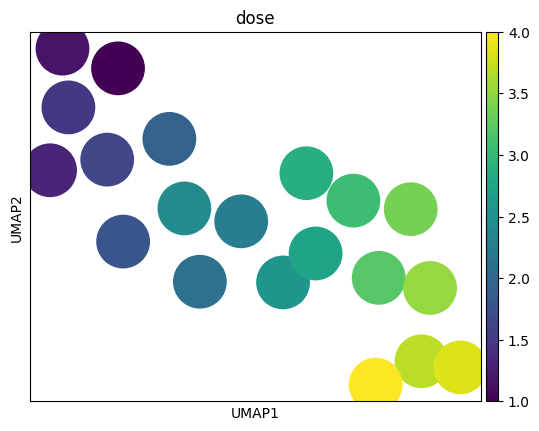

In [140]:

sc.pl.umap(bdata_unique, color="dose")

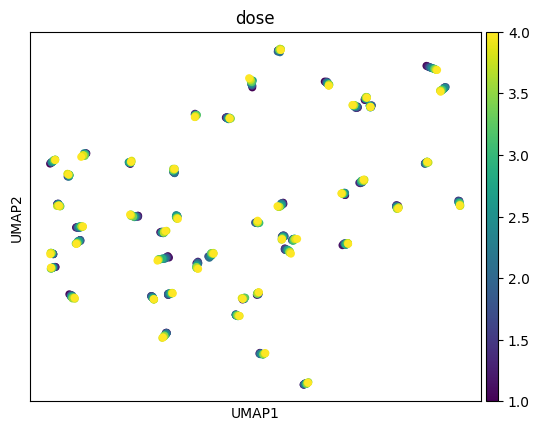

In [141]:
sc.pl.umap(bdata,  color="dose")

In [142]:
bdata.obs["condition"].value_counts()

condition
MCF7_Givinostat_(ITF2357)_1.0                   46
MCF7_Givinostat_(ITF2357)_1.631578947368421     46
MCF7_Givinostat_(ITF2357)_3.8421052631578947    46
MCF7_Givinostat_(ITF2357)_3.6842105263157894    46
MCF7_Givinostat_(ITF2357)_3.3684210526315788    46
MCF7_Givinostat_(ITF2357)_3.2105263157894735    46
MCF7_Givinostat_(ITF2357)_3.526315789473684     46
MCF7_Givinostat_(ITF2357)_3.052631578947368     46
MCF7_Givinostat_(ITF2357)_2.7368421052631575    46
MCF7_Givinostat_(ITF2357)_2.5789473684210527    46
MCF7_Givinostat_(ITF2357)_2.4210526315789473    46
MCF7_Givinostat_(ITF2357)_2.1052631578947367    46
MCF7_Givinostat_(ITF2357)_2.894736842105263     46
MCF7_Givinostat_(ITF2357)_2.263157894736842     46
MCF7_Givinostat_(ITF2357)_1.9473684210526314    46
MCF7_Givinostat_(ITF2357)_1.7894736842105263    46
MCF7_Givinostat_(ITF2357)_1.4736842105263157    46
MCF7_Givinostat_(ITF2357)_1.3157894736842106    46
MCF7_Givinostat_(ITF2357)_1.1578947368421053    46
MCF7_Givinostat_(ITF2

In [143]:
fdata = bdata[bdata.obs["dose"].isin([1.000000, 1.631578947368421, 2.894736842105263, 4.000000])]

In [144]:
fdata.obs["dose"].value_counts()

dose
1.000000    46
1.631579    46
2.894737    46
4.000000    46
Name: count, dtype: int64

In [145]:
sc.pp.neighbors(fdata)
sc.tl.umap(fdata)


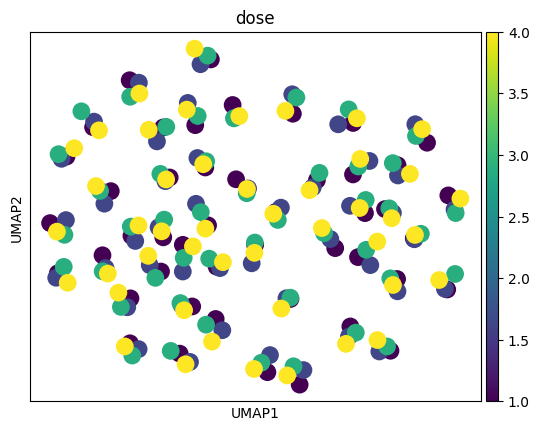

In [146]:
sc.pl.umap(fdata, color="dose")